# Deep Learning Model

In [37]:
#if necessary import the model data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Modeling Imports - GridSearch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import GridSearchCV

#CNN Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential
from tensorflow import feature_column
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

#validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [38]:
# A utility method to create a tf.data dataset from a Pandas Dataframe. Retrieved from tensorflow docs.
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [39]:
# A utility method to create a feature column
# and to transform a batch of data
from tensorflow.keras import layers
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [40]:
#A summary of missing variables represented as a percentage of the total missing content. 
def null_summary(df, print_log=False, sort='ascending'):
    s = df.isnull().sum()*100/df.isnull().count()
    
    if sort.lower() == 'ascending':
        s = s.sort_values(ascending=True)
    elif sort.lower() == 'descending':
        s = s.sort_values(ascending=False)  
    if print_log: 
        print('Percentage of null values: \n', s)
  
    return pd.Series(s)

In [41]:
#get the data
talkdata = pd.read_csv('/content/talkdata.csv')
#Quick look at the head.
talkdata.head()

,timestamp,longitude,latitude,coordinates,is_active,phone_brand,device_model,category,gender,age,group
0,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,1 free,M,35,M32-38
1,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Cozy 1,M,35,M32-38
2,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Industry tag,M,35,M32-38
3,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Property Industry 2.0,M,35,M32-38
4,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,music,M,35,M32-38


In [42]:
#The size and shape of this dataset before categorical changing.
talkdata.shape

(7832282, 11)

In [43]:
#Set the timestamp column to a datetime datatype.[Shame on me fo ridding myself of hte epoch timesetamp before I started the Deep learning]
talkdata['timestamp'] = pd.to_datetime(talkdata.timestamp)
talkdata.timestamp.dtype

#create the categorical time columns
talkdata['hour'] = talkdata.timestamp.dt.hour
talkdata['weekday'] = talkdata.timestamp.dt.dayofweek
#get the day of the week as an integer. 
talkdata['week'] = talkdata.timestamp.dt.isocalendar().week.astype(int)

#concatenate the phone brand to the device model. 
talkdata.describe(include='all', datetime_is_numeric=True)

,timestamp,longitude,latitude,coordinates,is_active,phone_brand,device_model,category,gender,age,group,hour,weekday,week
count,7832282,7.832282e+06,7.832282e+06,7832282,7.832282e+06,7832282,7832282,7832282,7832282,7.832282e+06,7832282,7.832282e+06,7.832282e+06,7.832282e+06
unique,NaN,NaN,NaN,32921,NaN,89,926,441,2,NaN,12,NaN,NaN,NaN
top,NaN,NaN,NaN,"(0.0, 0.0)",NaN,华为,荣耀6,Industry tag,M,NaN,M39+,NaN,NaN,NaN
freq,NaN,NaN,NaN,2295988,NaN,2422726,354430,907153,5566437,NaN,1360719,NaN,NaN,NaN
mean,2016-05-04 13:58:30.355242240,7.837463e+01,2.182485e+01,NaN,3.404700e-01,NaN,NaN,NaN,NaN,3.350478e+01,NaN,1.306016e+01,2.963128e+00,1.786502e+01
min,2016-04-30 23:52:24,-1.800000e+02,-3.380000e+01,NaN,0.000000e+00,NaN,NaN,NaN,NaN,1.100000e+01,NaN,0.000000e+00,0.000000e+00,1.700000e+01
25%,2016-05-02 20:22:46.500000,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN,2.700000e+01,NaN,8.000000e+00,1.000000e+00,1.800000e+01
50%,2016-05-04 14:05:48,1.127500e+02,2.857000e+01,NaN,0.000000e+00,NaN,NaN,NaN,NaN,3.100000e+01,NaN,1.300000e+01,3.000000e+00,1.800000e+01
75%,2016-05-06 08:22:22,1.171700e+02,3.401000e+01,NaN,1.000000e+00,NaN,NaN,NaN,NaN,3.900000e+01,NaN,1.900000e+01,5.000000e+00,1.800000e+01
max,2016-05-08 00:00:08,1.511800e+02,5.364000e+01,NaN,1.000000e+00,NaN,NaN,NaN,NaN,8.900000e+01,NaN,2.300000e+01,6.000000e+00,1.800000e+01


In [44]:
null_summary(talkdata)

timestamp       0.0
longitude       0.0
latitude        0.0
coordinates     0.0
is_active       0.0
phone_brand     0.0
device_model    0.0
category        0.0
gender          0.0
age             0.0
group           0.0
hour            0.0
weekday         0.0
week            0.0
dtype: float64

First I will classify on gender, because I need to get a working CNN model.

In [45]:
from sklearn.preprocessing import OrdinalEncoder
#Change the target variable to numeric, zero will represent the male population.
#talkdata['target'] = OrdinalEncoder().fit_transform(talkdata.group.values.reshape(-1,1))
talkdata['target'] = np.where(talkdata.gender == "M", 0, 1)

#This will get converted into a dataset later. 
X = talkdata.drop(columns=['hour', 'weekday', 'week', 'coordinates', 'gender', 'age', 'group'])
#We will be using tensorflow methods to work with the timestamp.
X['timestamp'] = talkdata['timestamp'].astype('int64')
X.shape

(7832282, 8)

In [46]:
train, test = train_test_split(X, test_size=0.5)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

3132912 train examples
783229 validation examples
3916141 test examples


In [47]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Feature Engineering

In [48]:
#Explore the dataset.
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['phone_brand'])
  print('A batch of targets:', label_batch )

Every feature: ['timestamp', 'longitude', 'latitude', 'is_active', 'phone_brand', 'device_model', 'category']
A batch of ages: tf.Tensor(
[b'OPPO' b'\xe4\xb8\x89\xe6\x98\x9f' b'\xe4\xb8\x89\xe6\x98\x9f'
 b'\xe4\xb8\xad\xe5\x85\xb4' b'\xe8\xaf\xad\xe4\xbf\xa1'], shape=(5,), dtype=string)
A batch of targets: tf.Tensor([0 0 1 0 0], shape=(5,), dtype=int64)


In [49]:
# Taking a look at feature columns
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [50]:
feature_columns = []

In [51]:
#Bucketizing these categorical columns that have fewer than 30 features.
is_active = feature_column.numeric_column('is_active')
is_active_buckets = feature_column.bucketized_column(is_active, boundaries=[0.])
feature_columns.append(is_active_buckets)

In [52]:
#Embedding column for my sparse categories. The dimension parameter must be tuned. 
time_cat = feature_column.categorical_column_with_vocabulary_list(
      'timestamp', X.timestamp.unique())
time_embedding = feature_column.embedding_column(time_cat, dimension=27)
feature_columns.append(time_embedding)

In [53]:
#Crossed feature columns - phone_brand and device_model
device_crossed_feature = feature_column.crossed_column(['device_model', 'phone_brand'], hash_bucket_size=16)
demo(feature_column.indicator_column(device_crossed_feature))

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [54]:
feature_columns.append(feature_column.indicator_column(device_crossed_feature))

In [55]:
#Crossed feature columns - phone_brand and device_model
coordinates_crossed_feature = feature_column.crossed_column(['latitude', 'longitude'], hash_bucket_size=23)
demo(feature_column.indicator_column(coordinates_crossed_feature))

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [56]:
feature_columns.append(feature_column.indicator_column(coordinates_crossed_feature))

In [57]:
#Embedding column for my sparse categories. The dimension parameter must be tuned. 
category = feature_column.categorical_column_with_vocabulary_list(
      'category', X.category.unique())
cat_embedding = feature_column.embedding_column(category, dimension=10)
demo(cat_embedding)

[[ 0.57553375  0.02443855 -0.37180257  0.08324161 -0.00302168 -0.13071118
  -0.37802738 -0.575648   -0.04787708  0.28132716]
 [ 0.1987541  -0.01999158 -0.20237263  0.27475223  0.03442423 -0.12258742
   0.16244562 -0.1238943  -0.1197976   0.19548585]
 [-0.3285712  -0.17856541 -0.1503316   0.19879375  0.39766684 -0.01329299
  -0.08342949 -0.35365027 -0.17669982  0.0214102 ]
 [ 0.06219751 -0.04508206 -0.18668914 -0.11838596  0.0983711  -0.55874676
  -0.09537187  0.48168135  0.04180591  0.27132407]
 [ 0.02041516 -0.1750339  -0.39342475  0.13116711 -0.01278052 -0.07975906
  -0.13575654 -0.33637714  0.42229134 -0.0630264 ]]


In [58]:
feature_columns.append(cat_embedding)

In [59]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [60]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [61]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
97902/97904 [============================>.] - ETA: 0s - loss: 0.4891 - accuracy: 0.7592WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'timestamp': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=int64>, 'longitude': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'is_active': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'phone_brand': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'device_model': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'category': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functional API.
97904/97904 [==============================] - 1200s 12ms/step - loss: 0.4891 - accuracy: 0.7592 - va

In [62]:
pred=model.predict(test_ds)

Consider rewriting this model with the Functional API.


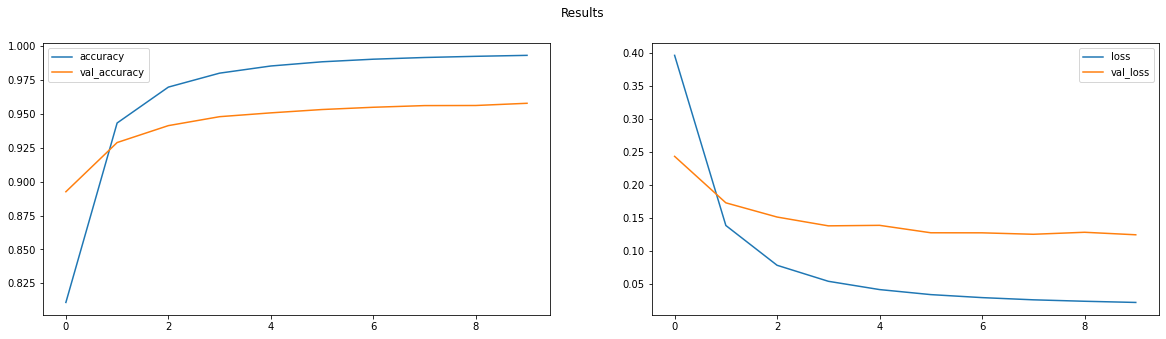

In [69]:
results = pd.DataFrame(history.history)

#Split the count plot.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
results[['accuracy', 'val_accuracy']].plot(ax=ax1)
results[['loss', 'val_loss']].plot(ax=ax2)
plt.show()







In [63]:
#Fix this to binary class identification. Re-reun classificationo report. 
from sklearn.metrics import classification_report

#predicted_class_indices=np.argmax(pred,axis=-1) 
predicted_class_indices=(pred > 0.5).astype("int32") #binary class identification.
y_true = test.target

print(classification_report(y_true, 
                            predicted_class_indices))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97   2783809
           1       0.94      0.91      0.93   1132332

    accuracy                           0.96   3916141
   macro avg       0.95      0.95      0.95   3916141
weighted avg       0.96      0.96      0.96   3916141

